<a href="https://colab.research.google.com/github/khojwar/Master_Thesis/blob/main/11_(Improve2_Breakthrough_second_success_another_experiment)_pos_tagging_using_lstm_without_loosing_sentence_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# !pip install tensorflow
# !pip install --upgrade gensim

In [8]:
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Update this line
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout  # Update this line


# step 1:  Extract sentences and pos_tags from xml file

In [9]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sentences = []
    pos_tags = []
    for sentence in root.findall('.//s'):
        words = []
        tags = []
        for word_elem in sentence.findall('./w'):
            words.append(word_elem.text)
            tags.append(word_elem.get('ctag'))
        sentences.append(words)
        pos_tags.append(tags)
    return sentences, pos_tags

In [10]:
file_path = "book-academic-jana-siksha-2058.xml"
sentences, pos_tags = parse_xml(file_path)

# Step 2: Word Embedding with word2vec

In [11]:
# created a Word2Vec model using Gensim in Python
from gensim.models import Word2Vec

def train_word2vec(sentences, embedding_dim=100):
    model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    return model

In [12]:
# Step 2: Word Embedding with word2vec
embedding_model = train_word2vec(sentences)
# embedding_model.wv.key_to_index

# Step 3: Preprocessing

In [13]:
# Create vocabulary and POS tag mapping
vocab = set([word for sentence in sentences for word in sentence])
pos_tags_set = set([tag for tags in pos_tags for tag in tags])
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}
tag_to_idx = {tag: idx for idx, tag in enumerate(pos_tags_set)}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

In [14]:
# Convert words and tags to indices
sentences_indices = [[word_to_idx[word] for word in sentence] for sentence in sentences]
pos_tags_indices = [[tag_to_idx[tag] for tag in tags] for tags in pos_tags]


In [15]:
# Pad sequences
max_sequence_length = max([len(seq) for seq in sentences_indices])
sentences_indices_padded = pad_sequences(sentences_indices, maxlen=max_sequence_length)
pos_tags_indices_padded = pad_sequences(pos_tags_indices, maxlen=max_sequence_length)


# Step 4: Splitting dataset into 70% train, 15% val, and 15% test

In [16]:
# Splitting data into 70% train, 30% temp
sentences_train, sentences_temp, pos_tags_train, pos_tags_temp = train_test_split(sentences_indices_padded, pos_tags_indices_padded, test_size=0.3, random_state=42)

# Splitting temp data into 50% val and 50% test
sentences_val, sentences_test, pos_tags_val, pos_tags_test = train_test_split(sentences_temp, pos_tags_temp, test_size=0.5, random_state=42)

# Step 5: Build the LSTM model

In [17]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_idx) + 1, output_dim=300, input_length=max_sequence_length))    # (number of unique words, 300-dimensional vector)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Adding a dropout layer with 30% dropout rate
model.add(Dense(64, activation='relu'))  # Adding an additional dense layer
model.add(TimeDistributed(Dense(len(tag_to_idx), activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 303, 300)          2017200   
                                                                 
 lstm (LSTM)                 (None, 303, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 303, 128)          0         
                                                                 
 dense (Dense)               (None, 303, 64)           8256      
                                                                 
 time_distributed (TimeDistr  (None, 303, 81)          5265      
 ibuted)                                                         
                                                                 
Total params: 2,250,369
Trainable params: 2,250,369
Non-trainable params: 0
______________________________________________

`(None, 303, 300)` represents the shape of the input and output of this embedding layer. Here, None indicates that the batch size can vary, 303 is the sequence length of each input, and 300 is the dimensionality of the embedding vector.

# Step 6: Compile the model

In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Step 7: Train the LSTM model with Train and val dataset

In [19]:
# Train the model
history = model.fit(sentences_train, pos_tags_train, epochs=10, batch_size=128, validation_data=(sentences_val, pos_tags_val), verbose=1)

Epoch 1/10
16/16 [==============================] - 37s 2s/step - loss: 0.8663 - accuracy: 0.8876 - val_loss: 0.1771 - val_accuracy: 0.9577
Epoch 2/10
16/16 [==============================] - 34s 2s/step - loss: 0.1576 - accuracy: 0.9618 - val_loss: 0.1514 - val_accuracy: 0.9625
Epoch 3/10
16/16 [==============================] - 32s 2s/step - loss: 0.1357 - accuracy: 0.9654 - val_loss: 0.1269 - val_accuracy: 0.9667
Epoch 4/10
16/16 [==============================] - 34s 2s/step - loss: 0.1100 - accuracy: 0.9681 - val_loss: 0.1056 - val_accuracy: 0.9710
Epoch 5/10
16/16 [==============================] - 36s 2s/step - loss: 0.0890 - accuracy: 0.9735 - val_loss: 0.0852 - val_accuracy: 0.9791
Epoch 6/10
16/16 [==============================] - 32s 2s/step - loss: 0.0640 - accuracy: 0.9824 - val_loss: 0.0606 - val_accuracy: 0.9875
Epoch 7/10
16/16 [==============================] - 34s 2s/step - loss: 0.0422 - accuracy: 0.9890 - val_loss: 0.0467 - val_accuracy: 0.9906
Epoch 8/10
16/16 [==

# Step 8: Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [20]:
# history_dict = history.history
# history_dict.keys()

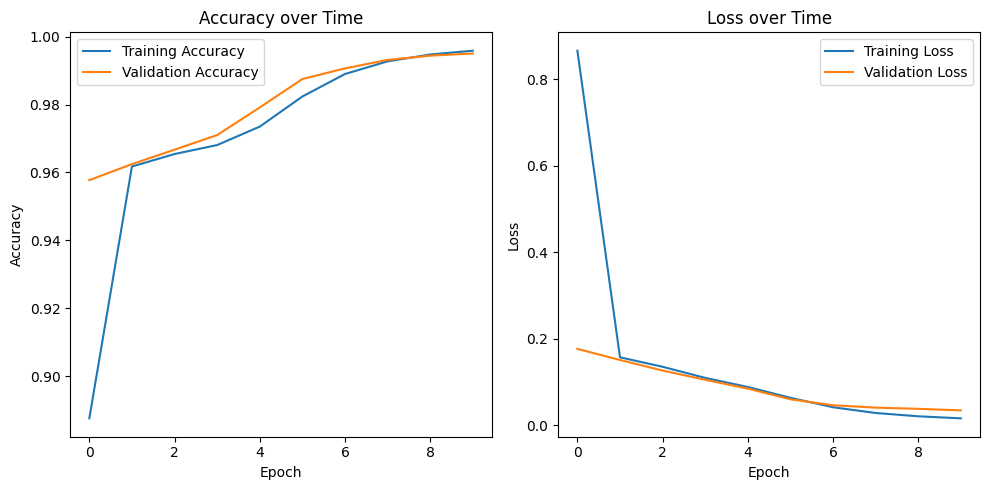

In [21]:
import matplotlib.pyplot as plt


# Plot accuracy over time
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over time
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Evaluate the model

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(sentences_test, pos_tags_test, verbose=1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

13/13 [==============================] - 4s 297ms/step - loss: 0.0308 - accuracy: 0.9953
Loss: 0.030820587649941444,
Accuracy: 0.9953411817550659


# Step 10: Plot the confusion matrix using Seaborn

13/13 [==============================] - 4s 239ms/step


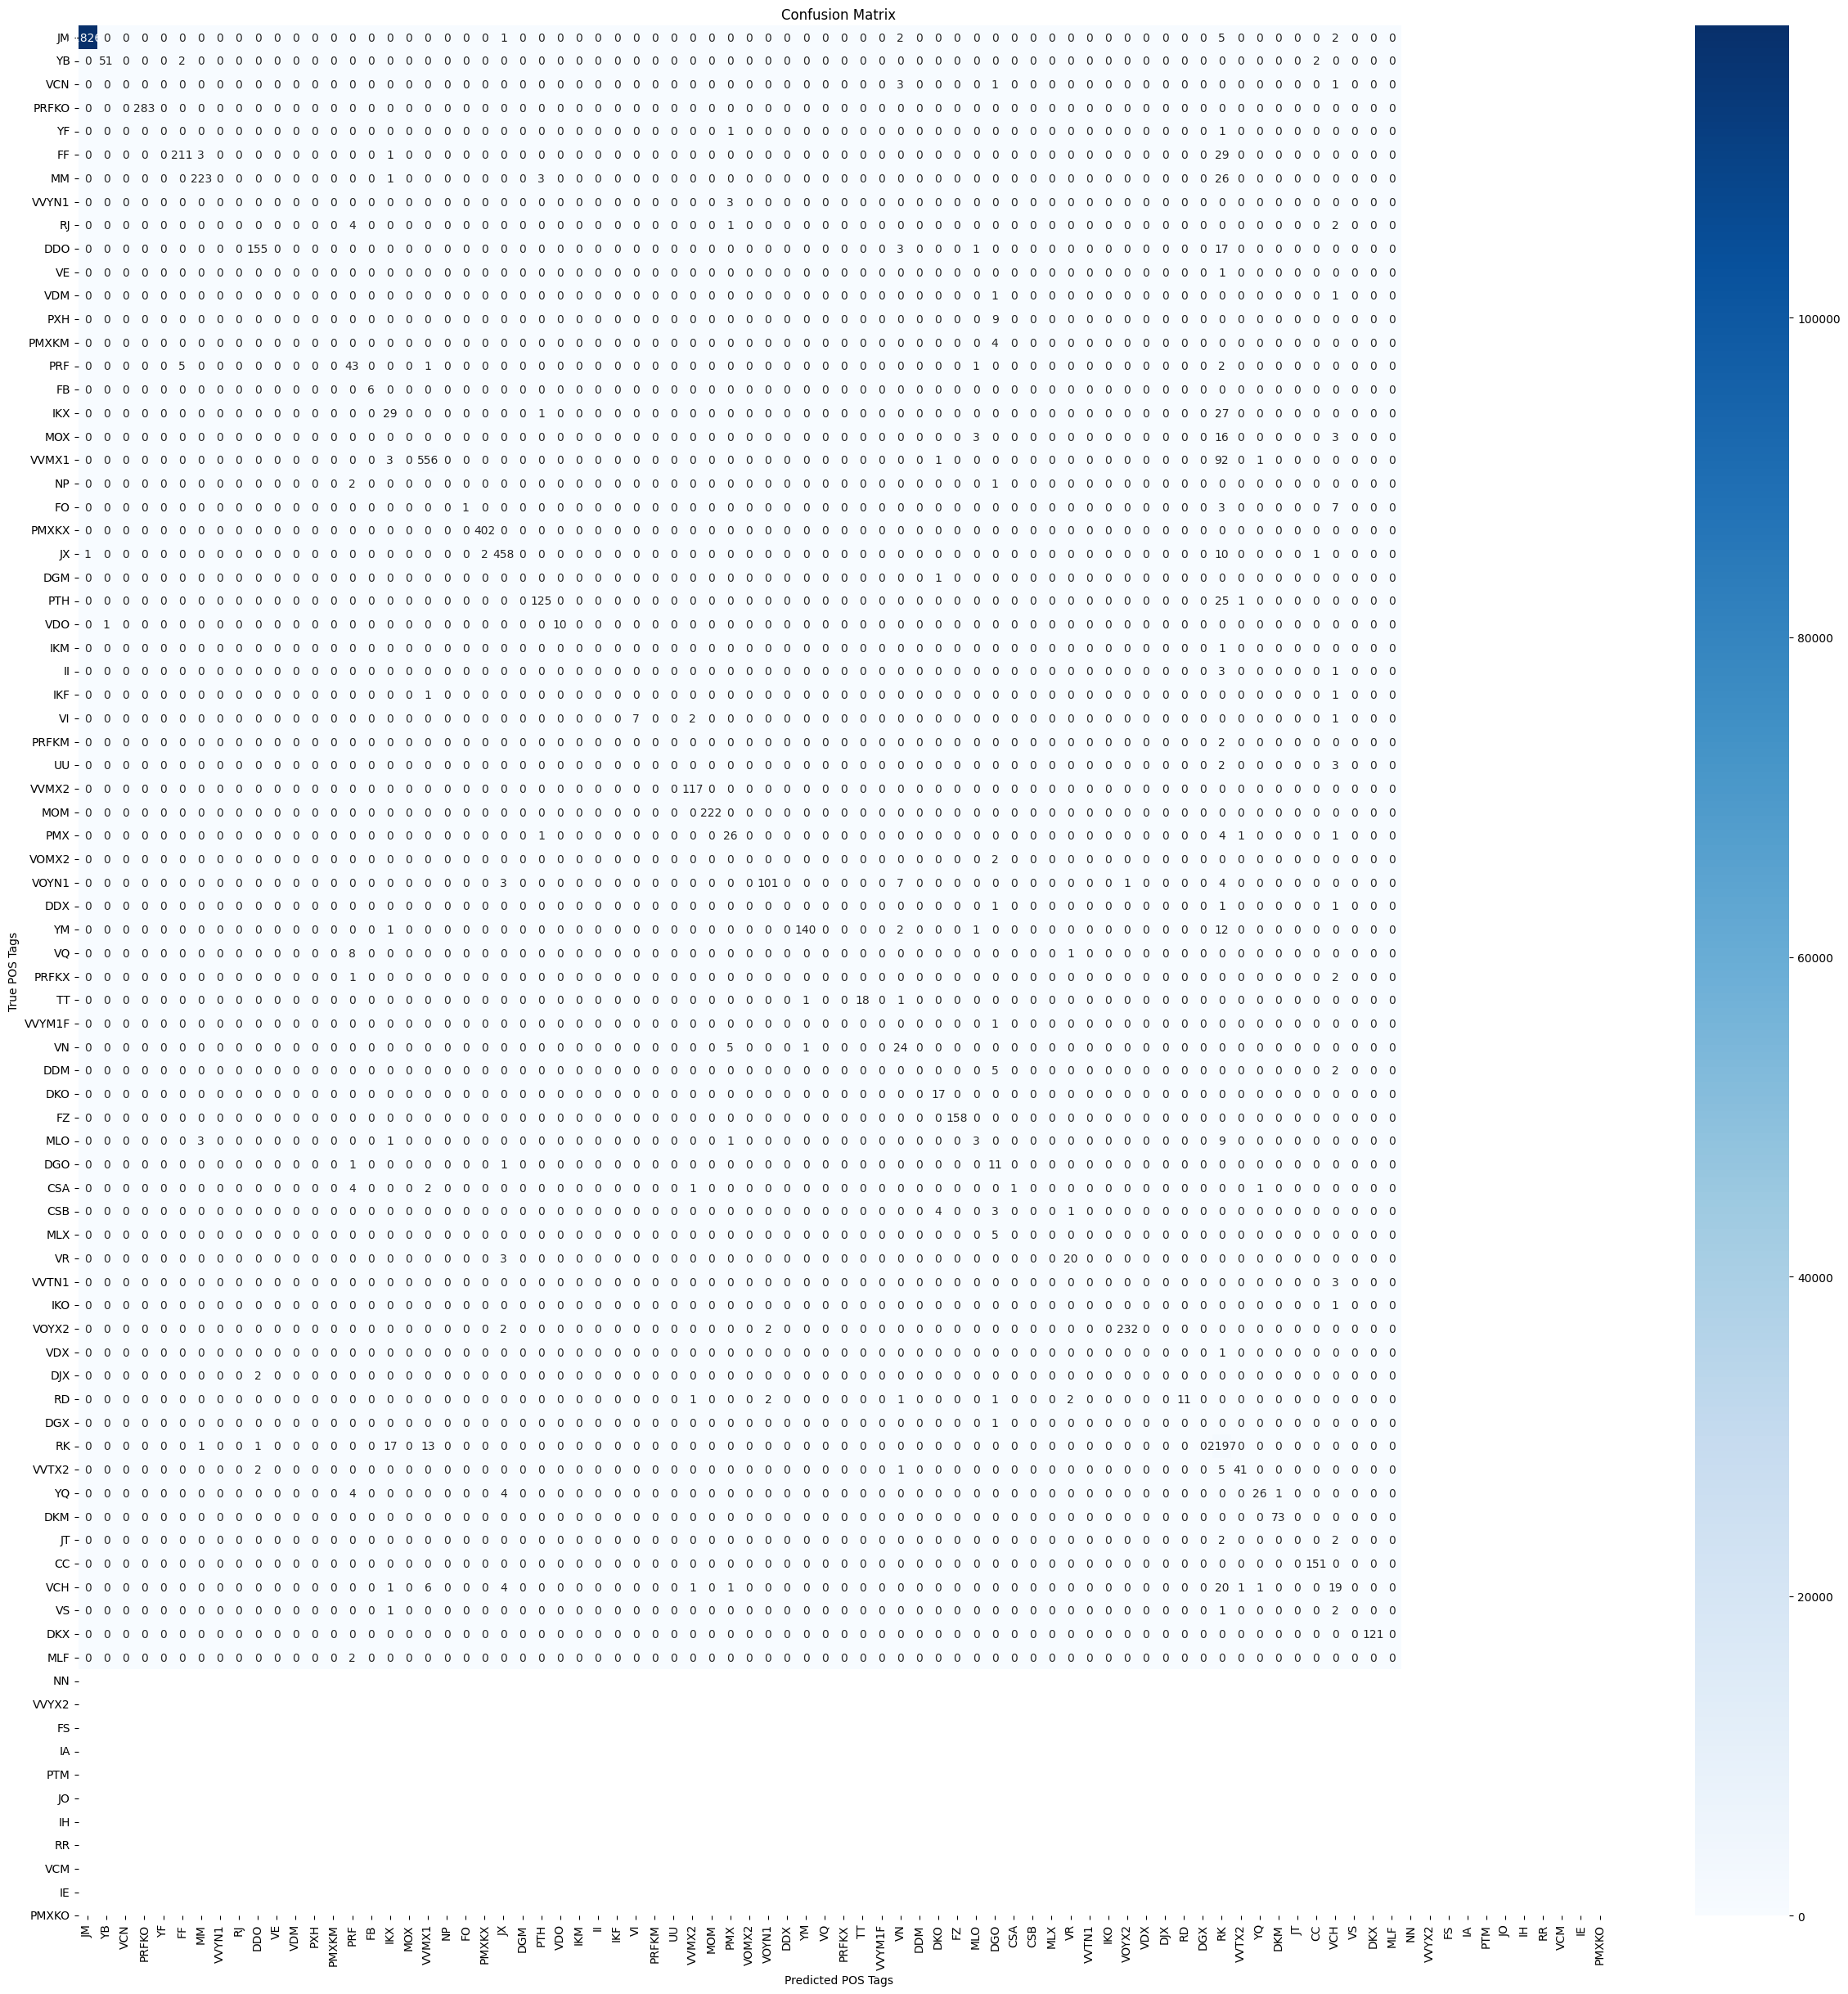

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict POS tags using the trained model
predicted_tags = model.predict(sentences_test)
predicted_tags = np.argmax(predicted_tags, axis=-1)

# Flatten the true and predicted tags arrays
true_tags_flat = np.ravel(pos_tags_test)
predicted_tags_flat = np.ravel(predicted_tags)

# Create a confusion matrix
confusion_mat = confusion_matrix(true_tags_flat, predicted_tags_flat)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_tag.values(), yticklabels=idx_to_tag.values())
plt.xlabel('Predicted POS Tags')
plt.ylabel('True POS Tags')
plt.title('Confusion Matrix')
plt.show()


# Step 11: Calculate precision, recall, F1 score and accuracy

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_tags_flat, predicted_tags_flat, average='weighted')
recall = recall_score(true_tags_flat, predicted_tags_flat, average='weighted')
f1 = f1_score(true_tags_flat, predicted_tags_flat, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.9948
Recall: 0.9953
F1 Score: 0.9949
Accuracy: 0.9953


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
from nltk.tokenize import word_tokenize

# Take user input sentence
new_sentence = input("Enter a sentence: ")
tokenized_new_sentence = word_tokenize(new_sentence.lower())
new_sentence_indices = [word_to_idx.get(word, 0) for word in tokenized_new_sentence]  # Use 0 if word is not in vocabulary

# Pad the input sequence to match the model's input length
padded_new_sentence_indices = pad_sequences([new_sentence_indices], maxlen=max_sequence_length, padding='post', value=0)

# Predict POS tags for the input sentence
predicted_tag_indices = model.predict(padded_new_sentence_indices)
predicted_tags = [idx_to_tag[idx] for idx in np.argmax(predicted_tag_indices, axis=-1)[0]]

# Print the POS tagged sentence
pos_tagged_sentence = list(zip(tokenized_new_sentence, predicted_tags))
for word, pos_tag in pos_tagged_sentence:
    print(f'{word}: {pos_tag}')


Enter a sentence: राम लेख लेख ।
1/1 [==============================] - 0s 204ms/step
राम: JM
लेख: NN
लेख: NN
।: YF
